<a href="https://colab.research.google.com/github/marreapato/Deep_Learning_Course/blob/main/final_project_mlcrs_course_models_gridsearch/My_FinalProjectAssignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
%cd /content/gdrive/MyDrive/mlcrs

!ls

/content/gdrive/MyDrive/mlcrs
access_log.txt			      KFoldCrossValidation.ipynb     Percentiles.ipynb
breakfast.jpg			      KMeans.ipynb		     PoliticsExercise.ipynb
bridge.jpg			      LinearRegression.ipynb	     PolynomialRegression.ipynb
bunny.jpg			      mammographic_masses.data.txt   Python101.ipynb
castle.jpg			      mammographic_masses.names.txt  regression.txt
ConditionalProbabilityExercise.ipynb  mammo_masses_project.ipynb     Seaborn.ipynb
ConditionalProbabilitySolution.ipynb  MatPlotLib.ipynb		     SparkDecisionTree.py
CovarianceCorrelation.ipynb	      MeanMedianExercise.ipynb	     SparkKMeans.py
DecisionTree.ipynb		      MeanMedianMode.ipynb	     SparkLinearRegression.py
DeepLearningProject.ipynb	      ml-100k			     SparkPCA.py
DeepLearningProject-Solution.ipynb    MLCourse.zip		     StdDevVariance.ipynb
distancerecomendation-KNN.ipynb       mlcrsItemBasedCF.ipynb	     subset-small.tsv
Distributions.ipynb		      mlcrsQ-Learning.ipynb	     SVC.ipynb
emails				      mlcrs_Sim

In [ ]:
data_dir = "/content/gdrive/MyDrive/mlcrs/mammographic_masses.data.txt"
data_dir1 = "/content/gdrive/MyDrive/mlcrs/mammographic_masses.names.txt"

# Final Project

## Predict whether a mammogram mass is benign or malignant

We'll be using the "mammographic masses" public dataset from the UCI repository (source: https://archive.ics.uci.edu/ml/datasets/Mammographic+Mass)

This data contains 961 instances of masses detected in mammograms, and contains the following attributes:


   1. BI-RADS assessment: 1 to 5 (ordinal)  
   2. Age: patient's age in years (integer)
   3. Shape: mass shape: round=1 oval=2 lobular=3 irregular=4 (nominal)
   4. Margin: mass margin: circumscribed=1 microlobulated=2 obscured=3 ill-defined=4 spiculated=5 (nominal)
   5. Density: mass density high=1 iso=2 low=3 fat-containing=4 (ordinal)
   6. Severity: benign=0 or malignant=1 (binominal)
   
BI-RADS is an assesment of how confident the severity classification is; it is not a "predictive" attribute and so we will discard it. The age, shape, margin, and density attributes are the features that we will build our model with, and "severity" is the classification we will attempt to predict based on those attributes.

Although "shape" and "margin" are nominal data types, which sklearn typically doesn't deal with well, they are close enough to ordinal that we shouldn't just discard them. The "shape" for example is ordered increasingly from round to irregular.

A lot of unnecessary anguish and surgery arises from false positives arising from mammogram results. If we can build a better way to interpret them through supervised machine learning, it could improve a lot of lives.

## Your assignment

Apply several different supervised machine learning techniques to this data set, and see which one yields the highest accuracy as measured with K-Fold cross validation (K=10). Apply:

* Decision tree
* Random forest
* KNN
* Naive Bayes
* SVM
* Logistic Regression
* And, as a bonus challenge, a neural network using Keras.

The data needs to be cleaned; many rows contain missing data, and there may be erroneous data identifiable as outliers as well.

Remember some techniques such as SVM also require the input data to be normalized first.

Many techniques also have "hyperparameters" that need to be tuned. Once you identify a promising approach, see if you can make it even better by tuning its hyperparameters.

I was able to achieve over 80% accuracy - can you beat that?

Below I've set up an outline of a notebook for this project, with some guidance and hints. If you're up for a real challenge, try doing this project from scratch in a new, clean notebook!


## Let's begin: prepare your data

Start by importing the mammographic_masses.data.txt file into a Pandas dataframe (hint: use read_csv) and take a look at it.

In [ ]:
import pandas as pd

data_mam = pd.read_csv(data_dir, header = None, na_values="?")
data_mam.head(5)

,0,1,2,3,4,5
0,5.0,67.0,3.0,5.0,3.0,1
1,4.0,43.0,1.0,1.0,NaN,1
2,5.0,58.0,4.0,5.0,3.0,1
3,4.0,28.0,1.0,1.0,3.0,0
4,5.0,74.0,1.0,5.0,NaN,1


Make sure you use the optional parmaters in read_csv to convert missing data (indicated by a ?) into NaN, and to add the appropriate column names (BI_RADS, age, shape, margin, density, and severity):

In [ ]:
data_mam.rename(columns={0: "BI_RADS", 1:"age",2:"shape",3:"margin",4:"density",5:"severity"},inplace = True)
data_mam.head(2)

,BI_RADS,age,shape,margin,density,severity
0,5.0,67.0,3.0,5.0,3.0,1
1,4.0,43.0,1.0,1.0,NaN,1


In [ ]:
#data_mam.replace(to_replace = "?",value = None,inplace = True )
#data_mam.head(2)

Evaluate whether the data needs cleaning; your model is only as good as the data it's given. Hint: use describe() on the dataframe.

In [ ]:
data_mam.describe()

,BI_RADS,age,shape,margin,density,severity
count,959.000000,956.000000,930.000000,913.000000,885.000000,961.000000
mean,4.348279,55.487448,2.721505,2.796276,2.910734,0.463059
std,1.783031,14.480131,1.242792,1.566546,0.380444,0.498893
min,0.000000,18.000000,1.000000,1.000000,1.000000,0.000000
25%,4.000000,45.000000,2.000000,1.000000,3.000000,0.000000
50%,4.000000,57.000000,3.000000,3.000000,3.000000,0.000000
75%,5.000000,66.000000,4.000000,4.000000,3.000000,1.000000
max,55.000000,96.000000,4.000000,5.000000,4.000000,1.000000


There are quite a few missing values in the data set. Before we just drop every row that's missing data, let's make sure we don't bias our data in doing so. Does there appear to be any sort of correlation to what sort of data has missing fields? If there were, we'd have to try and go back and fill that data in.

In [ ]:
data_mam.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 961 entries, 0 to 960
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   BI_RADS   959 non-null    float64
 1   age       956 non-null    float64
 2   shape     930 non-null    float64
 3   margin    913 non-null    float64
 4   density   885 non-null    float64
 5   severity  961 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 45.2 KB


If the missing data seems randomly distributed, go ahead and drop rows with missing data. Hint: use dropna().

In [ ]:
data_mam.dropna(inplace = True)
data_mam.describe()

,BI_RADS,age,shape,margin,density,severity
count,830.000000,830.000000,830.000000,830.000000,830.000000,830.000000
mean,4.393976,55.781928,2.781928,2.813253,2.915663,0.485542
std,1.888371,14.671782,1.242361,1.567175,0.350936,0.500092
min,0.000000,18.000000,1.000000,1.000000,1.000000,0.000000
25%,4.000000,46.000000,2.000000,1.000000,3.000000,0.000000
50%,4.000000,57.000000,3.000000,3.000000,3.000000,0.000000
75%,5.000000,66.000000,4.000000,4.000000,3.000000,1.000000
max,55.000000,96.000000,4.000000,5.000000,4.000000,1.000000


In [ ]:
data_mam[['shape','margin','density']] = data_mam[['shape','margin','density']].astype(str)
data_mam.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 830 entries, 0 to 960
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   BI_RADS   830 non-null    float64
 1   age       830 non-null    float64
 2   shape     830 non-null    object 
 3   margin    830 non-null    object 
 4   density   830 non-null    object 
 5   severity  830 non-null    int64  
dtypes: float64(2), int64(1), object(3)
memory usage: 45.4+ KB


In [ ]:
# Get one hot encoding of columns B
one_hot = pd.get_dummies(data_mam[['shape','margin','density']])
# Drop column B as it is now encoded
df_mam = data_mam.drop(['shape','margin','density'],axis = 1)
# Join the encoded df
df_mam = data_mam.join(one_hot).drop(['shape','margin','density'],axis = 1)
df_mam.head(5)

,BI_RADS,age,severity,shape_1.0,shape_2.0,shape_3.0,shape_4.0,margin_1.0,margin_2.0,margin_3.0,margin_4.0,margin_5.0,density_1.0,density_2.0,density_3.0,density_4.0
0,5.0,67.0,1,0,0,1,0,0,0,0,0,1,0,0,1,0
2,5.0,58.0,1,0,0,0,1,0,0,0,0,1,0,0,1,0
3,4.0,28.0,0,1,0,0,0,1,0,0,0,0,0,0,1,0
8,5.0,57.0,1,1,0,0,0,0,0,0,0,1,0,0,1,0
10,5.0,76.0,1,1,0,0,0,0,0,0,1,0,0,0,1,0


In [ ]:
df_mam.columns

Index(['BI_RADS', 'age', 'severity', 'shape_1.0', 'shape_2.0', 'shape_3.0',
       'shape_4.0', 'margin_1.0', 'margin_2.0', 'margin_3.0', 'margin_4.0',
       'margin_5.0', 'density_1.0', 'density_2.0', 'density_3.0',
       'density_4.0'],
      dtype='object')

In [ ]:
df_mam.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 830 entries, 0 to 960
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   BI_RADS      830 non-null    float64
 1   age          830 non-null    float64
 2   severity     830 non-null    int64  
 3   shape_1.0    830 non-null    uint8  
 4   shape_2.0    830 non-null    uint8  
 5   shape_3.0    830 non-null    uint8  
 6   shape_4.0    830 non-null    uint8  
 7   margin_1.0   830 non-null    uint8  
 8   margin_2.0   830 non-null    uint8  
 9   margin_3.0   830 non-null    uint8  
 10  margin_4.0   830 non-null    uint8  
 11  margin_5.0   830 non-null    uint8  
 12  density_1.0  830 non-null    uint8  
 13  density_2.0  830 non-null    uint8  
 14  density_3.0  830 non-null    uint8  
 15  density_4.0  830 non-null    uint8  
dtypes: float64(2), int64(1), uint8(13)
memory usage: 68.8 KB


Next you'll need to convert the Pandas dataframes into numpy arrays that can be used by scikit_learn. Create an array that extracts only the feature data we want to work with (age, shape, margin, and density) and another array that contains the classes (severity). You'll also need an array of the feature name labels.

In [ ]:
X = df_mam.drop(["BI_RADS","severity"],axis = 1)
y = df_mam[['severity']]
print(X)
print(y)

      age  shape_1.0  shape_2.0  shape_3.0  shape_4.0  margin_1.0  margin_2.0  \
0    67.0          0          0          1          0           0           0   
2    58.0          0          0          0          1           0           0   
3    28.0          1          0          0          0           1           0   
8    57.0          1          0          0          0           0           0   
10   76.0          1          0          0          0           0           0   
..    ...        ...        ...        ...        ...         ...         ...   
956  47.0          0          1          0          0           1           0   
957  56.0          0          0          0          1           0           0   
958  64.0          0          0          0          1           0           0   
959  66.0          0          0          0          1           0           0   
960  62.0          0          0          1          0           0           0   

     margin_3.0  margin_4.0

In [ ]:
from sklearn.model_selection import train_test_split

trainX, testX, trainy, testy = train_test_split(X,y,test_size = 0.25,random_state=323,stratify=y)
print(trainX,testX,trainy,testy)

      age  shape_1.0  shape_2.0  shape_3.0  shape_4.0  margin_1.0  margin_2.0  \
448  54.0          0          0          0          1           0           0   
331  51.0          1          0          0          0           1           0   
449  80.0          0          0          0          1           0           0   
870  65.0          0          0          0          1           0           0   
899  61.0          0          0          1          0           0           0   
..    ...        ...        ...        ...        ...         ...         ...   
399  74.0          0          0          0          1           0           0   
400  58.0          1          0          0          0           1           0   
404  70.0          0          0          0          1           0           0   
456  69.0          0          0          0          1           0           0   
811  65.0          0          0          1          0           0           0   

     margin_3.0  margin_4.0

Some of our models require the input data to be normalized, so go ahead and normalize the attribute data. Hint: use preprocessing.StandardScaler().

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

scaler = StandardScaler()

trainX[['age']] = scaler.fit_transform(trainX[['age']])
testX[['age']] = scaler.transform(testX[['age']])
print(testX)

          age  shape_1.0  shape_2.0  shape_3.0  shape_4.0  margin_1.0  \
64   1.223020          0          0          0          1           0   
172 -0.197619          0          0          0          1           0   
633  0.817123          0          0          0          1           0   
767 -0.197619          0          0          1          0           0   
877 -0.332918          0          1          0          0           0   
..        ...        ...        ...        ...        ...         ...   
383 -0.738815          1          0          0          0           1   
492 -0.197619          1          0          0          0           1   
836 -0.941763          0          1          0          0           1   
810  1.290669          0          0          0          1           0   
274  0.072979          0          0          0          1           0   

     margin_2.0  margin_3.0  margin_4.0  margin_5.0  density_1.0  density_2.0  \
64            0           0           1   

## Decision Trees

Before moving to K-Fold cross validation and random forests, start by creating a single train/test split of our data. Set aside 75% for training, and 25% for testing.

Now create a DecisionTreeClassifier and fit it to your training data.

In [ ]:
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier(random_state = 2)#,max_depth=4)
model.fit(trainX,trainy)

predicted = model.predict(testX)
predicted

array([1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0,
       1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1,
       1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1,
       1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1,
       0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1,
       0, 0, 0, 1, 0, 0, 0, 1, 1, 0])

Display the resulting decision tree.

In [ ]:
print(model.feature_importances_)
print(trainX.columns)

[0.31915134 0.02162613 0.03750174 0.01453417 0.03897679 0.46057218
 0.00635906 0.03888544 0.01965518 0.02149797 0.00250828 0.00943082
 0.00851691 0.00078399]
Index(['age', 'shape_1.0', 'shape_2.0', 'shape_3.0', 'shape_4.0', 'margin_1.0',
       'margin_2.0', 'margin_3.0', 'margin_4.0', 'margin_5.0', 'density_1.0',
       'density_2.0', 'density_3.0', 'density_4.0'],
      dtype='object')


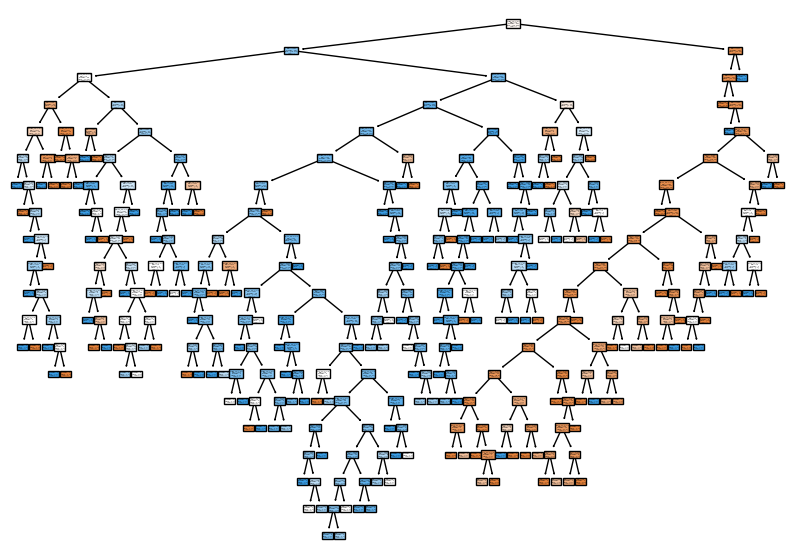

In [ ]:
import matplotlib.pyplot as plt
from sklearn import tree

fig = plt.figure(figsize = (10, 7))
tree.plot_tree(model, feature_names = trainX.columns,
              class_names = ['0','1'], filled = True)
plt.show()

Measure the accuracy of the resulting decision tree model using your test data.

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [ ]:
accuracy_score(testy,predicted)

0.6778846153846154

In [ ]:
confusion_matrix(testy, predicted)

array([[80, 27],
       [40, 61]])

In [ ]:
print(classification_report(testy,predicted))

              precision    recall  f1-score   support

           0       0.67      0.75      0.70       107
           1       0.69      0.60      0.65       101

    accuracy                           0.68       208
   macro avg       0.68      0.68      0.68       208
weighted avg       0.68      0.68      0.68       208



Now instead of a single train/test split, use K-Fold cross validation to get a better measure of your model's accuracy (K=10). Hint: use model_selection.cross_val_score

In [ ]:
from sklearn.model_selection import cross_val_score, KFold

kfold = KFold(n_splits=10,shuffle = True,random_state = 4)
scores = cross_val_score(model,X,y,cv = kfold)

In [ ]:
scores.mean()

0.7530120481927711

Now try a RandomForestClassifier instead. Does it perform better?

In [ ]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(random_state = 5)
model.fit(trainX,trainy)
predicted = model.predict(testX)
predicted

<ipython-input-29-e68d04f44623>:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(trainX,trainy)


array([1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0,
       1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1,
       1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0,
       0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1,
       0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0,
       0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1,
       0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1,
       1, 1, 0, 1, 1, 0, 0, 1, 1, 0])

In [ ]:
accuracy_score(testy,predicted)

0.7403846153846154

In [ ]:
confusion_matrix(testy,predicted)

array([[76, 31],
       [23, 78]])

In [ ]:
print(classification_report(testy,predicted))

              precision    recall  f1-score   support

           0       0.77      0.71      0.74       107
           1       0.72      0.77      0.74       101

    accuracy                           0.74       208
   macro avg       0.74      0.74      0.74       208
weighted avg       0.74      0.74      0.74       208



In [ ]:
kfold = KFold(n_splits=10,random_state = 4, shuffle = True)
scores = cross_val_score(model, X,y, cv = kfold)
scores


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed whe

array([0.72289157, 0.79518072, 0.74698795, 0.79518072, 0.80722892,
       0.73493976, 0.75903614, 0.74698795, 0.73493976, 0.85542169])

In [ ]:
scores.mean()

0.7698795180722892

## SVM

Next try using svm.SVC with a linear kernel. How does it compare to the decision tree?

In [ ]:
from sklearn.svm import SVC

In [ ]:
model = SVC(random_state = 3,C = 1.2, kernel = 'linear')
model.fit(trainX,trainy)
predicted = model.predict(testX)
predicted

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0,
       1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1,
       1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1,
       0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0,
       1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0,
       1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1,
       0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0,
       1, 0, 0, 1, 0, 0, 0, 0, 1, 1])

In [ ]:
accuracy_score(testy,predicted)

0.7884615384615384

In [ ]:
confusion_matrix(testy,predicted)

array([[81, 26],
       [18, 83]])

In [ ]:
print(classification_report(testy,predicted))

              precision    recall  f1-score   support

           0       0.82      0.76      0.79       107
           1       0.76      0.82      0.79       101

    accuracy                           0.79       208
   macro avg       0.79      0.79      0.79       208
weighted avg       0.79      0.79      0.79       208



In [ ]:
kfold = KFold(random_state = 3,n_splits=10,shuffle = True)
scores = cross_val_score(model,X,y,cv = kfold)
scores

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

array([0.8313253 , 0.75903614, 0.81927711, 0.78313253, 0.84337349,
       0.79518072, 0.78313253, 0.72289157, 0.78313253, 0.86746988])

In [ ]:
scores.mean()

0.7987951807228916

## KNN
How about K-Nearest-Neighbors? Hint: use neighbors.KNeighborsClassifier - it's a lot easier than implementing KNN from scratch like we did earlier in the course. Start with a K of 10. K is an example of a hyperparameter - a parameter on the model itself which may need to be tuned for best results on your particular data set.

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

model = KNeighborsClassifier(n_neighbors=4,weights = 'distance')
model.fit(trainX,trainy)
predicted = model.predict(testX)
predicted

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


array([1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0,
       1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1,
       1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0,
       0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1,
       0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1,
       1, 0, 0, 1, 0, 0, 0, 1, 1, 0])

In [ ]:
accuracy_score(testy,predicted)

0.7211538461538461

Choosing K is tricky, so we can't discard KNN until we've tried different values of K. Write a for loop to run KNN with K values ranging from 1 to 50 and see if K makes a substantial difference. Make a note of the best performance you could get out of KNN.

In [ ]:
import numpy as np
array_accuracy = list()
for i in range(0,50):
  model = KNeighborsClassifier(n_neighbors=i+1,weights = 'distance')
  model.fit(trainX,trainy)
  predicted = model.predict(testX)
  array_accuracy.append(accuracy_score(testy,predicted))

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for 

In [ ]:
np.array(array_accuracy).argmax()


18

In [ ]:
np.array(array_accuracy)[18]

0.7451923076923077

In [ ]:
np.array(array_accuracy).max()

0.7451923076923077

SO K = 19

## Naive Bayes

Now try naive_bayes.MultinomialNB. How does its accuracy stack up? Hint: you'll need to use MinMaxScaler to get the features in the range MultinomialNB requires.

In [ ]:
xtrain, xtest, ytrain, ytest = train_test_split(X,y,test_size = 0.25,random_state=323,stratify=y)

scalermax = MinMaxScaler()

xtrain[['age']] = scalermax.fit_transform(xtrain[['age']])
xtest[['age']] = scalermax.transform(xtest[['age']])
print(xtest)

          age  shape_1.0  shape_2.0  shape_3.0  shape_4.0  margin_1.0  \
64   0.717949          0          0          0          1           0   
172  0.448718          0          0          0          1           0   
633  0.641026          0          0          0          1           0   
767  0.448718          0          0          1          0           0   
877  0.423077          0          1          0          0           0   
..        ...        ...        ...        ...        ...         ...   
383  0.346154          1          0          0          0           1   
492  0.448718          1          0          0          0           1   
836  0.307692          0          1          0          0           1   
810  0.730769          0          0          0          1           0   
274  0.500000          0          0          0          1           0   

     margin_2.0  margin_3.0  margin_4.0  margin_5.0  density_1.0  density_2.0  \
64            0           0           1   

In [ ]:
from sklearn.naive_bayes import MultinomialNB

model = MultinomialNB(alpha = 1)
model.fit(xtrain,ytrain)
predicted = model.predict(xtest)
predicted

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0,
       1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1,
       1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1,
       0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0,
       1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0,
       1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1,
       0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 1, 1])

In [ ]:
accuracy_score(ytest,predicted)

0.7836538461538461

In [ ]:
confusion_matrix(ytest,predicted)

array([[83, 24],
       [21, 80]])

In [ ]:
print(classification_report(ytest,predicted))

              precision    recall  f1-score   support

           0       0.80      0.78      0.79       107
           1       0.77      0.79      0.78       101

    accuracy                           0.78       208
   macro avg       0.78      0.78      0.78       208
weighted avg       0.78      0.78      0.78       208



## Revisiting SVM

svm.SVC may perform differently with different kernels. The choice of kernel is an example of a "hyperparamter." Try the rbf, sigmoid, and poly kernels and see what the best-performing kernel is. Do we have a new winner?

In [ ]:
model = SVC(kernel = 'rbf',random_state = 3, C=1.1)
model.fit(trainX,trainy)
predicted = model.predict(testX)
predicted

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0,
       1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1,
       1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1,
       0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0,
       1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1,
       0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0,
       1, 0, 0, 1, 0, 0, 0, 0, 1, 1])

In [ ]:
accuracy_score(testy,predicted)

0.7884615384615384

In [ ]:
model = SVC(kernel = 'sigmoid',random_state = 3, C=1.1)
model.fit(trainX,trainy)
predicted = model.predict(testX)
predicted

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1,
       1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1,
       1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0,
       0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0,
       1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1,
       0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0,
       1, 0, 0, 1, 0, 0, 0, 0, 1, 1])

In [ ]:
accuracy_score(testy,predicted)

0.6586538461538461

In [ ]:
model = SVC(kernel = 'poly',random_state = 3, C=1.1)
model.fit(trainX,trainy)
predicted = model.predict(testX)
predicted

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0,
       1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1,
       1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0,
       0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1,
       0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0,
       1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1,
       0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0,
       1, 0, 0, 1, 0, 0, 0, 0, 1, 1])

In [ ]:
accuracy_score(testy,predicted)

0.7932692307692307

## Logistic Regression

We've tried all these fancy techniques, but fundamentally this is just a binary classification problem. Try Logisitic Regression, which is a simple way to tackling this sort of thing.

In [ ]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(random_state = 3)
model.fit(trainX,trainy)
predicted = model.predict(testX)
predicted

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0,
       1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1,
       1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1,
       0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0,
       1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1,
       0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0,
       1, 0, 0, 1, 0, 0, 0, 0, 1, 1])

In [ ]:
accuracy_score(testy,predicted)

0.7788461538461539

In [ ]:
print(classification_report(testy,predicted))

              precision    recall  f1-score   support

           0       0.80      0.76      0.78       107
           1       0.76      0.80      0.78       101

    accuracy                           0.78       208
   macro avg       0.78      0.78      0.78       208
weighted avg       0.78      0.78      0.78       208



## Neural Networks

As a bonus challenge, let's see if an artificial neural network can do even better. You can use Keras to set up a neural network with 1 binary output neuron and see how it performs. Don't be afraid to run a large number of epochs to train the model if necessary.

In [197]:
import tensorflow as tf

In [202]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import (Dense,
    Dropout)

In [249]:
model = Sequential()
model.add(Dense(units = 512,input_dim = trainX.shape[1],activation = 'relu'))
model.add(Dropout(0.8))
model.add(Dense(units = 512,activation = 'relu'))
model.add(Dropout(0.9))
model.add(Dense(units = 2,activation = 'softmax'))

model.summary()

Model: "sequential_41"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_181 (Dense)           (None, 512)               7680      
                                                                 
 dropout_70 (Dropout)        (None, 512)               0         
                                                                 
 dense_182 (Dense)           (None, 512)               262656    
                                                                 
 dropout_71 (Dropout)        (None, 512)               0         
                                                                 
 dense_183 (Dense)           (None, 2)                 1026      
                                                                 
Total params: 271362 (1.04 MB)
Trainable params: 271362 (1.04 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [250]:
model.compile(loss="categorical_crossentropy", metrics=["accuracy"],optimizer = "Adam")

In [251]:
#from keras.callbacks import EarlyStopping

#early_stopping = EarlyStopping(monitor='val_loss', patience=50, min_delta=10**(-6)) ,callbacks=early_stopping
history = model.fit(trainX,tf.keras.utils.to_categorical(trainy, num_classes=2),epochs = 400,verbose = 1,batch_size=32,validation_data=(testX,tf.keras.utils.to_categorical(testy, num_classes=2)))

Epoch 1/400
20/20 [==============================] - 2s 32ms/step - loss: 0.7144 - accuracy: 0.5547 - val_loss: 0.5252 - val_accuracy: 0.7788
Epoch 2/400
20/20 [==============================] - 0s 17ms/step - loss: 0.5730 - accuracy: 0.7154 - val_loss: 0.4707 - val_accuracy: 0.7500
Epoch 3/400
20/20 [==============================] - 0s 10ms/step - loss: 0.5213 - accuracy: 0.7765 - val_loss: 0.4584 - val_accuracy: 0.7788
Epoch 4/400
20/20 [==============================] - 0s 9ms/step - loss: 0.5112 - accuracy: 0.7669 - val_loss: 0.4595 - val_accuracy: 0.7837
Epoch 5/400
20/20 [==============================] - 0s 10ms/step - loss: 0.4994 - accuracy: 0.7894 - val_loss: 0.4608 - val_accuracy: 0.7837
Epoch 6/400
20/20 [==============================] - 0s 9ms/step - loss: 0.4820 - accuracy: 0.7878 - val_loss: 0.4588 - val_accuracy: 0.7981
Epoch 7/400
20/20 [==============================] - 0s 9ms/step - loss: 0.4959 - accuracy: 0.8023 - val_loss: 0.4638 - val_accuracy: 0.7933
Epoch 8/4

In [252]:
score, acc = model.evaluate(testX, tf.keras.utils.to_categorical(testy, num_classes=2),
                            batch_size=32,
                            verbose=2)
print('Test score:', score)
print('Test accuracy:', acc)

7/7 - 0s - loss: 0.6854 - accuracy: 0.8029 - 112ms/epoch - 16ms/step
Test score: 0.6854391098022461
Test accuracy: 0.8028846383094788


In [285]:
model.predict(np.array(testX.iloc[8]).reshape(-1,14))

1/1 [==============================] - 0s 49ms/step


array([[9.9999964e-01, 3.4255373e-07]], dtype=float32)

In [284]:
testy.iloc[8]

severity    0
Name: 850, dtype: int64

In [286]:
model.predict(np.array(testX.iloc[2]).reshape(-1,14))

1/1 [==============================] - 0s 40ms/step


array([[0.18298732, 0.81701267]], dtype=float32)

In [287]:
testy.iloc[2]

severity    1
Name: 633, dtype: int64

In [288]:
model = Sequential()
model.add(Dense(units = 512,input_dim = trainX.shape[1],activation = 'relu'))
model.add(Dropout(0.8))
model.add(Dense(units = 512,activation = 'relu'))
model.add(Dropout(0.9))
model.add(Dense(units = 1,activation = 'sigmoid'))

model.summary()

Model: "sequential_42"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_184 (Dense)           (None, 512)               7680      
                                                                 
 dropout_72 (Dropout)        (None, 512)               0         
                                                                 
 dense_185 (Dense)           (None, 512)               262656    
                                                                 
 dropout_73 (Dropout)        (None, 512)               0         
                                                                 
 dense_186 (Dense)           (None, 1)                 513       
                                                                 
Total params: 270849 (1.03 MB)
Trainable params: 270849 (1.03 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [289]:
model.compile(loss="binary_crossentropy", metrics=["accuracy"],optimizer = "Adam")

In [290]:
#from keras.callbacks import EarlyStopping

#early_stopping = EarlyStopping(monitor='val_loss', patience=50, min_delta=10**(-6)) ,callbacks=early_stopping
history = model.fit(trainX,trainy,epochs = 400,verbose = 1,batch_size=32,validation_data=(testX,testy))

Epoch 1/400
20/20 [==============================] - 2s 28ms/step - loss: 0.6783 - accuracy: 0.5932 - val_loss: 0.5356 - val_accuracy: 0.7404
Epoch 2/400
20/20 [==============================] - 0s 17ms/step - loss: 0.5346 - accuracy: 0.7331 - val_loss: 0.4712 - val_accuracy: 0.7596
Epoch 3/400
20/20 [==============================] - 0s 14ms/step - loss: 0.5084 - accuracy: 0.7894 - val_loss: 0.4595 - val_accuracy: 0.7692
Epoch 4/400
20/20 [==============================] - 0s 15ms/step - loss: 0.5132 - accuracy: 0.7958 - val_loss: 0.4585 - val_accuracy: 0.7788
Epoch 5/400
20/20 [==============================] - 0s 15ms/step - loss: 0.4706 - accuracy: 0.7974 - val_loss: 0.4614 - val_accuracy: 0.7837
Epoch 6/400
20/20 [==============================] - 0s 17ms/step - loss: 0.4945 - accuracy: 0.7974 - val_loss: 0.4652 - val_accuracy: 0.7837
Epoch 7/400
20/20 [==============================] - 0s 16ms/step - loss: 0.4772 - accuracy: 0.7990 - val_loss: 0.4657 - val_accuracy: 0.7933
Epoch 

In [292]:
score, acc = model.evaluate(testX, testy,
                            batch_size=32,
                            verbose=2)
print('Test score:', score)
print('Test accuracy:', acc)

7/7 - 0s - loss: 0.6683 - accuracy: 0.8077 - 101ms/epoch - 14ms/step
Test score: 0.6683028340339661
Test accuracy: 0.807692289352417


In [293]:
model.predict(np.array(testX.iloc[8]).reshape(-1,14))

1/1 [==============================] - 0s 138ms/step


array([[5.4440403e-07]], dtype=float32)

In [294]:
testy.iloc[8]#small probability of being 1

severity    0
Name: 850, dtype: int64

In [297]:
predicted = model.predict(testX)
# Apply threshold (e.g., 0.5) to classify as 0 or 1
threshold = 0.5
binary_predictions = (predicted > threshold).astype(int)
print(classification_report(testy,binary_predictions))

7/7 [==============================] - 0s 4ms/step
              precision    recall  f1-score   support

           0       0.84      0.78      0.81       107
           1       0.78      0.84      0.81       101

    accuracy                           0.81       208
   macro avg       0.81      0.81      0.81       208
weighted avg       0.81      0.81      0.81       208



In [298]:
confusion_matrix(testy,binary_predictions)

array([[83, 24],
       [16, 85]])

## Do we have a winner?

Which model, and which choice of hyperparameters, performed the best? Feel free to share your results!

In [308]:
from sklearn.model_selection import GridSearchCV

modelclf = KNeighborsClassifier()
# Exemplo dos parâmetros que quero testar.
parametros = {'n_neighbors':[19, 55, 3,5],
              'weights':["distance", "uniform"]}

grid_search = GridSearchCV(estimator = modelclf,param_grid = parametros,verbose=3)
grid_search.fit(trainX,trainy)
melhores_parametros = grid_search.best_params_
melhor_resultado = grid_search.best_score_


Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END ..n_neighbors=19, weights=distance;, score=0.736 total time=   0.0s
[CV 2/5] END ..n_neighbors=19, weights=distance;, score=0.776 total time=   0.0s
[CV 3/5] END ..n_neighbors=19, weights=distance;, score=0.790 total time=   0.0s
[CV 4/5] END ..n_neighbors=19, weights=distance;, score=0.766 total time=   0.0s
[CV 5/5] END ..n_neighbors=19, weights=distance;, score=0.798 total time=   0.0s
[CV 1/5] END ...n_neighbors=19, weights=uniform;, score=0.784 total time=   0.0s
[CV 2/5] END ...n_neighbors=19, weights=uniform;, score=0.816 total time=   0.0s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for 

[CV 3/5] END ...n_neighbors=19, weights=uniform;, score=0.782 total time=   0.1s
[CV 4/5] END ...n_neighbors=19, weights=uniform;, score=0.758 total time=   0.1s
[CV 5/5] END ...n_neighbors=19, weights=uniform;, score=0.855 total time=   0.1s
[CV 1/5] END ..n_neighbors=55, weights=distance;, score=0.736 total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for 

[CV 2/5] END ..n_neighbors=55, weights=distance;, score=0.760 total time=   0.0s
[CV 3/5] END ..n_neighbors=55, weights=distance;, score=0.815 total time=   0.0s
[CV 4/5] END ..n_neighbors=55, weights=distance;, score=0.766 total time=   0.1s
[CV 5/5] END ..n_neighbors=55, weights=distance;, score=0.806 total time=   0.0s
[CV 1/5] END ...n_neighbors=55, weights=uniform;, score=0.792 total time=   0.0s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for 

[CV 2/5] END ...n_neighbors=55, weights=uniform;, score=0.808 total time=   0.0s
[CV 3/5] END ...n_neighbors=55, weights=uniform;, score=0.815 total time=   0.0s
[CV 4/5] END ...n_neighbors=55, weights=uniform;, score=0.750 total time=   0.0s
[CV 5/5] END ...n_neighbors=55, weights=uniform;, score=0.855 total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for 

[CV 1/5] END ...n_neighbors=3, weights=distance;, score=0.760 total time=   0.0s
[CV 2/5] END ...n_neighbors=3, weights=distance;, score=0.744 total time=   0.0s
[CV 3/5] END ...n_neighbors=3, weights=distance;, score=0.766 total time=   0.0s
[CV 4/5] END ...n_neighbors=3, weights=distance;, score=0.782 total time=   0.0s
[CV 5/5] END ...n_neighbors=3, weights=distance;, score=0.790 total time=   0.0s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


[CV 1/5] END ....n_neighbors=3, weights=uniform;, score=0.800 total time=   0.1s
[CV 2/5] END ....n_neighbors=3, weights=uniform;, score=0.784 total time=   0.1s
[CV 3/5] END ....n_neighbors=3, weights=uniform;, score=0.790 total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


[CV 4/5] END ....n_neighbors=3, weights=uniform;, score=0.758 total time=   0.1s
[CV 5/5] END ....n_neighbors=3, weights=uniform;, score=0.815 total time=   0.1s
[CV 1/5] END ...n_neighbors=5, weights=distance;, score=0.752 total time=   0.0s
[CV 2/5] END ...n_neighbors=5, weights=distance;, score=0.744 total time=   0.0s
[CV 3/5] END ...n_neighbors=5, weights=distance;, score=0.790 total time=   0.0s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for 

[CV 4/5] END ...n_neighbors=5, weights=distance;, score=0.782 total time=   0.0s
[CV 5/5] END ...n_neighbors=5, weights=distance;, score=0.774 total time=   0.0s
[CV 1/5] END ....n_neighbors=5, weights=uniform;, score=0.792 total time=   0.1s
[CV 2/5] END ....n_neighbors=5, weights=uniform;, score=0.800 total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


[CV 3/5] END ....n_neighbors=5, weights=uniform;, score=0.815 total time=   0.1s
[CV 4/5] END ....n_neighbors=5, weights=uniform;, score=0.766 total time=   0.1s
[CV 5/5] END ....n_neighbors=5, weights=uniform;, score=0.831 total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


In [309]:
print(melhores_parametros)
print(melhor_resultado)

{'n_neighbors': 55, 'weights': 'uniform'}
0.8038709677419356


In [310]:
best_model = grid_search.best_estimator_
y_pred = best_model.predict(testX)

# Evaluate accuracy on validation set
accuracy = accuracy_score(testy, y_pred)
print("Validation Accuracy: %.2f%%" % (accuracy * 100))

Validation Accuracy: 78.85%


In [311]:
confusion_matrix(testy, y_pred)

array([[80, 27],
       [17, 84]])

In [312]:
print(classification_report(testy, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.75      0.78       107
           1       0.76      0.83      0.79       101

    accuracy                           0.79       208
   macro avg       0.79      0.79      0.79       208
weighted avg       0.79      0.79      0.79       208

